In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple, deque, defaultdict

import copy
from tqdm import tqdm
import csv

from datetime import datetime, timedelta

In [10]:
class State:
	def __init__(self, b : float, p : np.ndarray, h : np.ndarray, max_stocks : int):
		"""
		self.b: Balance at the state.
		self.p: Numpy array of prices of all stickers being tracked, dtype = float.
		self.h: Numpy array of amount held of all stickers being tracked, dtype = int. We will have a limit on the maximum number of units of a single ticker we can hold.
		This determines the size of the action space.
  		"""
		self.b = b
		self.p = p
		self.h = h
		self.max_stocks = max_stocks

	def is_valid_action(self, action):
		## action is an array/tuple

		## check 1: enough stocks
		for i in range(len(self.h)):
			if self.h[i] + action[i] < 0: return False

		## check 2: new balance is non-negative
		new_balance = self.b
		for i in range(len(self.h)):
			new_balance -= action[i] * self.p[i]
		if new_balance < 0: return False

		return True

	def get_tup(self):
		ids = [self.b] + [p for p in self.p] + [h for h in self.h]
		return tuple(ids)


In [11]:
"""
Load CSVs of chosen stocks, divide them by date into a train, validation, and test set. The data should be in a form that supports trajectory sampling.
"""

# Train: 2015-2017
# Validation: 2018
# Test: [2019 - ]

time_delta_days = 7

class Data:
    def __init__(self, filenames, time_delta_days = time_delta_days):
        """
        List of maps, [<date, opening_price>]
        """
        self.ticker_data = []
        self.time_delta_days = time_delta_days

        for file in filenames:
			# Extract ticker name
            ticker_name = file.split('.')[0]
            ticker_name = ticker_name.split('/')[-1]
            self.ticker_data.append(dict())
            pricereader = csv.DictReader(open(file))
            for row in pricereader:
                start_date = row['Date']
                date_format = '%Y-%m-%d'
                date = datetime.strptime(start_date, date_format)
                self.ticker_data[-1][date] = float(row['Open'])

    def get(self, date):
        prices = []
        for i, ticker_dct in enumerate(self.ticker_data):
            if date in ticker_dct:
                price = ticker_dct[date]
            else:
                price = self.get(date-timedelta(days=self.time_delta_days))[i]
            prices.append(price)
        return np.array(prices)

In [12]:
def generate_combinations(dimensions, current=[]):
    if not dimensions:
        return [tuple(current)]
    else:
        currents = []
        for value in range(-dimensions[0], dimensions[0]+1):
            currents.extend(generate_combinations(dimensions[1:], current + [value]))
        return currents

class StockTradingEnv:
    def __init__(self, initial_balance: float, max_stocks: int, n_tickers: int, gamma: float, start_date, possible_actions):
        """
        self.initial_balance: Amount of money that the model starts with. We assume that we have no stocks at the starting state.
        self.max_stocks: The maximum number of units of any stock we can buy or sell in an action.
        self.n_tickers: Number of stocks our model will trade on.
        self.Q: Dictionary of (state, action) pairs to utility. Populated dynamically.
        """
        self.initial_balance = initial_balance
        self.max_stocks = max_stocks
        self.n_tickers = n_tickers
        self.state_count = defaultdict(int)
        self.gamma = gamma
        self.start_date = start_date
        self.possible_actions = possible_actions
        self.reset(start_date)

    def step(self, a: int):
        action = self.possible_actions[a]
        old_p = data.get(self.current_date)
        self.current_date += timedelta(time_delta_days)
        new_p = data.get(self.current_date)
        new_b = self.current_state.b - np.sum(old_p*np.array(action))
        new_h = self.current_state.h + np.array(action)
        next_state = State(new_b, new_p, new_h, self.current_state.max_stocks)
        reward = next_state.b - self.current_state.b + np.sum(next_state.p*next_state.h) - np.sum(self.current_state.p*self.current_state.h)
        if new_b < 0 or (new_h<0).sum()>0:
            print(new_b, new_h)
            print(self.current_state.get_tup())
            print(self.next_state.get_tup())
            print(action)
            reward = -100000
        self.current_state = next_state
        return self.current_state, reward

    def reset(self, date):
        if date:
            self.current_date = copy.deepcopy(date)
        else:
            self.current_date = copy.deepcopy(self.start_date)
        self.current_state = State(self.initial_balance, data.get(self.current_date), np.zeros(n_tickers), max_stocks)
        return self.current_state


gamma = 0.9  # Discount factor
rollouts_per_date = 3000  # Number of epochs for training
date_format = '%m/%d/%y'
start_dates = ['1/3/11', '1/4/11', '1/5/11', '1/6/11', '1/7/11']
start_dates = [datetime.strptime(o, date_format) for o in start_dates]
n_tickers = 2
initial_balance = 10000.0
max_stocks = 5
rollout_depth = 20
possible_actions = generate_combinations([max_stocks]*n_tickers)

filenames = ['VOO.csv', 'VTI.csv']
data = Data(filenames)
env = StockTradingEnv(initial_balance, max_stocks, n_tickers, gamma, start_dates[0], possible_actions)

In [13]:


# Hyperparameters
BUFFER_SIZE = 40000 #50
BATCH_SIZE = 64
GAMMA = 0.9
ALPHA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 60
TARGET_UPDATE = 10
num_episodes = 150
ROLLOUT_DEPTH = 20

# Define the Q-network TODO
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the ReplayBuffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        return random.sample(self.buffer, k=batch_size)

# Define the DQN Agent
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)

        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)

        self.steps_done = 0
        self.output_size = output_size

    def select_action(self, state, eps_threshold_eval=None):
        if eps_threshold_eval:
            eps_threshold = eps_threshold_eval
        else:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        valid_action_idxs = [i for i in range(len(possible_actions)) if state.is_valid_action(possible_actions[i])]
        if random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(np.array(state.get_tup())).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                action = valid_action_idxs[q_values[0, valid_action_idxs].argmax().item()]
        else:
            action = random.choice(valid_action_idxs)
        return action

    def learn(self):
        if len(self.replay_buffer.buffer) < BATCH_SIZE:
            return

        experiences = self.replay_buffer.sample(BATCH_SIZE)
        batch = self.experience_to_batch(experiences)

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch

        q_values = self.q_network(state_batch).gather(1, action_batch)

        next_q_values = self.target_network(next_state_batch).max(1)[0].unsqueeze(1)
        expected_q_values = reward_batch + (1 - done_batch) * ALPHA * GAMMA * next_q_values

        # loss = F.smooth_l1_loss(q_values, expected_q_values)
        loss = F.mse_loss(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        loss_hist.append(loss.item())
        self.optimizer.step()

        if self.steps_done % TARGET_UPDATE == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def experience_to_batch(self, experiences):
        batch = self.replay_buffer.experience(*zip(*experiences))
        state_batch = torch.FloatTensor(batch.state)
        action_batch = torch.LongTensor(batch.action).view(-1, 1)
        reward_batch = torch.FloatTensor(batch.reward).view(-1, 1)
        next_state_batch = torch.FloatTensor(batch.next_state)
        done_batch = torch.FloatTensor(batch.done).view(-1, 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

# Initialize environment and agent
input_size = 2*n_tickers + 1
output_size = (2*max_stocks+1)**n_tickers
agent = DQNAgent(input_size, output_size)

# Training loop
loss_hist, reward_hist = [], []

for episode in range(num_episodes):

    total_reward = 0
    for start_date in start_dates:
        state = env.reset(start_date)
        rollout_depth = ROLLOUT_DEPTH

        while rollout_depth > 0:
            action = agent.select_action(state)
            if rollout_depth == 1:
                done = 1
            else:
                done = 0
            next_state, reward = env.step(action)
            agent.replay_buffer.add(state.get_tup(), action, reward, next_state.get_tup(), done)

            agent.learn()

            total_reward += reward*((GAMMA)**(ROLLOUT_DEPTH-rollout_depth))
            state = next_state

            rollout_depth -= 1

    print(f"Episode: {episode + 1}, Mean Discounted Reward w/o Learning: {total_reward/len(start_dates)}")
    reward_hist.append(total_reward)

# for episode in range(num_episodes):

#     total_reward = 0
#     for start_date in start_dates:
#         state = env.reset(start_date)
#         rollout_depth = ROLLOUT_DEPTH

#         while rollout_depth > 0:
#             action = agent.select_action(state)
#             if rollout_depth == 1:
#                 done = 1
#             else:
#                 done = 0
#             next_state, reward = env.step(action)
#             agent.replay_buffer.add(state.get_tup(), action, reward, next_state.get_tup(), done)

#             agent.learn()

#             total_reward += reward*((GAMMA)**(ROLLOUT_DEPTH-rollout_depth))
#             state = next_state

#             rollout_depth -= 1

#     print(f"Episode: {episode + 1}, Mean Discounted Reward w/ Learning: {total_reward/len(start_dates)}")
#     reward_hist.append(total_reward)



Episode: 1, Mean Discounted Reward w/o Learning: 64.24753722650354
Episode: 2, Mean Discounted Reward w/o Learning: 89.53587220873318
Episode: 3, Mean Discounted Reward w/o Learning: 95.82707507509974
Episode: 4, Mean Discounted Reward w/o Learning: 101.87028275360873
Episode: 5, Mean Discounted Reward w/o Learning: 89.95363513355095
Episode: 6, Mean Discounted Reward w/o Learning: 96.6530606773261
Episode: 7, Mean Discounted Reward w/o Learning: 66.34803550080328
Episode: 8, Mean Discounted Reward w/o Learning: 102.73360592539159
Episode: 9, Mean Discounted Reward w/o Learning: 97.23304699987766
Episode: 10, Mean Discounted Reward w/o Learning: 88.22580505135178
Episode: 11, Mean Discounted Reward w/o Learning: 52.83050699589619
Episode: 12, Mean Discounted Reward w/o Learning: 65.36532215559824
Episode: 13, Mean Discounted Reward w/o Learning: 77.26426328570057
Episode: 14, Mean Discounted Reward w/o Learning: 65.55317187076106
Episode: 15, Mean Discounted Reward w/o Learning: 104.38

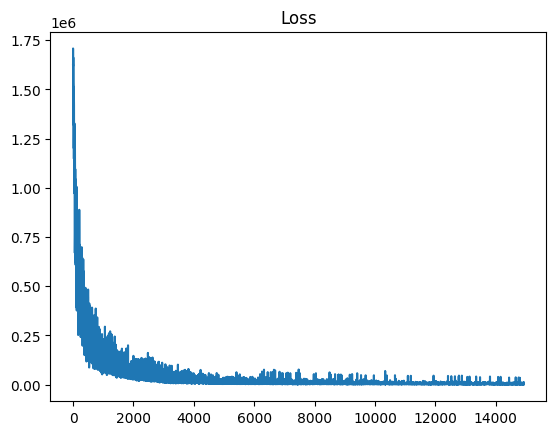

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_hist)
plt.title('Loss')
plt.show()

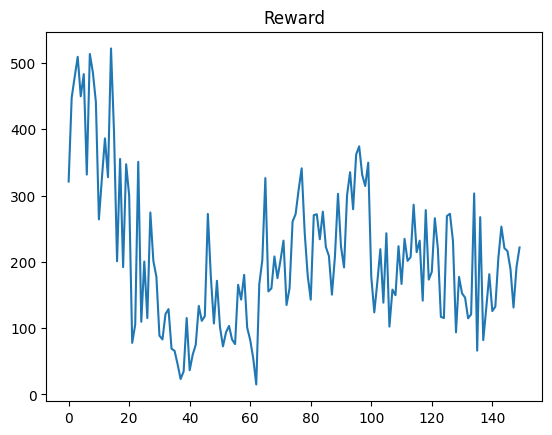

In [15]:
plt.figure()
plt.plot(reward_hist)
plt.title('Reward')
plt.show()

## Evaluation

In [16]:
rollouts_per_date = 80
ROLLOUT_DEPTH = 20
# eval_start_dates = ['1/3/11', '1/4/11', '1/5/11', '1/6/11', '1/7/11']
eval_start_dates = ['1/4/12', '1/5/12', '1/6/12', '1/9/12', '1/9/12']

mean_discounted_reward = 0
for start_date in eval_start_dates:
    for rollout in range(rollouts_per_date):

        state = env.reset(datetime.strptime(start_date, date_format))
        rollout_depth = ROLLOUT_DEPTH

        while rollout_depth > 0:
            action = agent.select_action(state, 0)
            next_state, reward = env.step(action)

            mean_discounted_reward += reward*((GAMMA)**(ROLLOUT_DEPTH-rollout_depth))
            state = next_state

            rollout_depth -= 1

mean_discounted_reward /= rollouts_per_date * len(eval_start_dates)
print('Mean Discounted Reward %.4f, rollout_depth %s, start_dates %s' % (mean_discounted_reward, ROLLOUT_DEPTH, eval_start_dates))

Mean Discounted Reward 100.9016, rollout_depth 20, start_dates ['1/4/12', '1/5/12', '1/6/12', '1/9/12', '1/9/12']
